In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from prophet import Prophet

from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import yfinance as yf



ModuleNotFoundError: No module named 'pandas'

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def mean_absolute_percentage_error (y_true,y_pred):
    y_true, y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

#### The Data will be using is Hourly power consumption data from PJM.

In [ ]:
msft = yf.download("MSFT", start="2003-01-01", end="2023-06-30")
msft_close = msft['Close'].reset_index()

[*********************100%%**********************]  1 of 1 completed


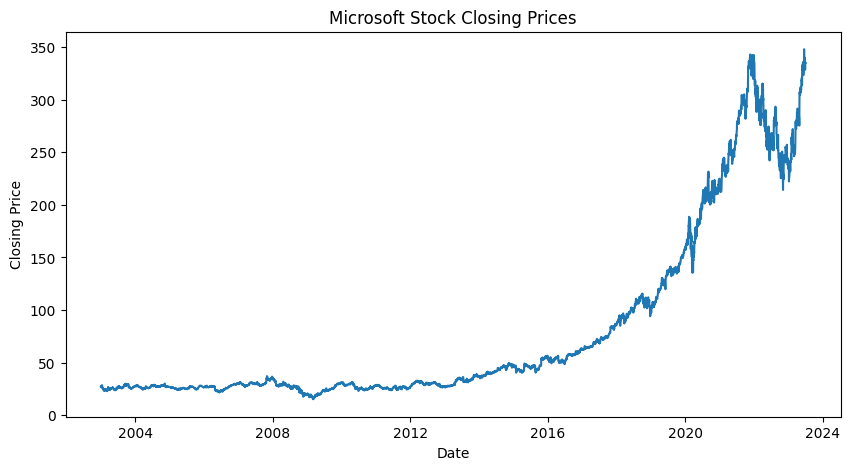

In [ ]:
color_pal = sns.color_palette()
plt.figure(figsize=(10, 5))
sns.lineplot(x='Date', y='Close', data=msft_close, color=color_pal[0])
plt.title('Microsoft Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [ ]:
from pandas.api.types import CategoricalDtype

msft_df = msft.copy()

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(msft_df, label='Close')
features_and_target = pd.concat([X, y], axis=1)

# Display the features and target
print(features_and_target.head())

            dayofweek  quarter  month  year  dayofyear  dayofmonth   
Date                                                                 
2003-01-02          3        1      1  2003          2           2  \
2003-01-03          4        1      1  2003          3           3   
2003-01-06          0        1      1  2003          6           6   
2003-01-07          1        1      1  2003          7           7   
2003-01-08          2        1      1  2003          8           8   

            weekofyear    weekday  season      Close  
Date                                                  
2003-01-02           1   Thursday  Winter  26.860001  
2003-01-03           1     Friday  Winter  26.895000  
2003-01-06           2     Monday  Winter  27.385000  
2003-01-07           2    Tuesday  Winter  27.900000  
2003-01-08           2  Wednesday  Winter  27.120001  


In [ ]:
features_and_target.head()

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,Close
Date,,,,,,,,,,
2003-01-02,3,1,1,2003,2,2,1,Thursday,Winter,26.860001
2003-01-03,4,1,1,2003,3,3,1,Friday,Winter,26.895000
2003-01-06,0,1,1,2003,6,6,2,Monday,Winter,27.385000
2003-01-07,1,1,1,2003,7,7,2,Tuesday,Winter,27.900000
2003-01-08,2,1,1,2003,8,8,2,Wednesday,Winter,27.120001


#### Let's  plot the above time series features into box plot

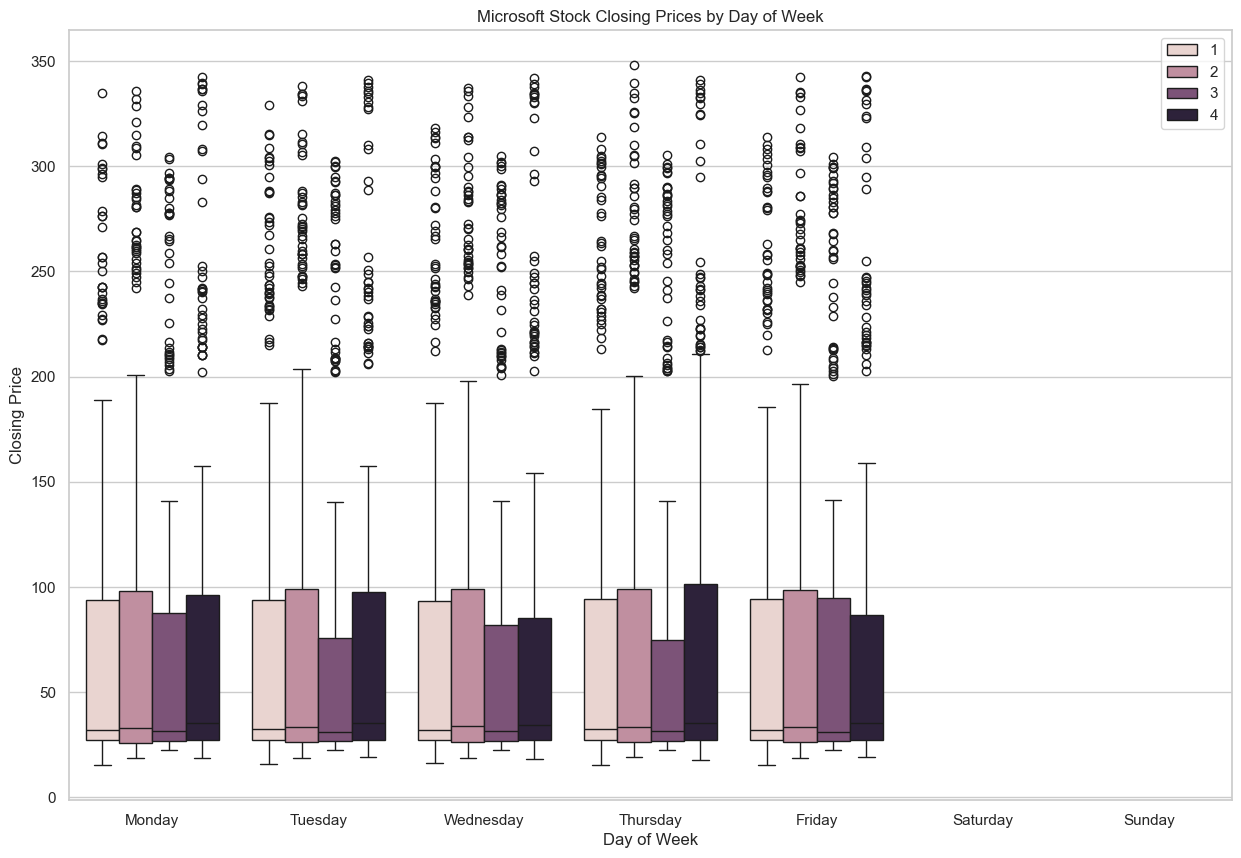

In [ ]:
# Create a DataFrame for plotting
features_for_plotting = pd.concat([X, y], axis=1)

# Set the style of seaborn
sns.set(style="whitegrid")

# Plot boxplots for each feature
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=features_for_plotting.dropna(),
            x='weekday',
            y='Close',  # Replace with the actual column name you are interested in
            hue='quarter',
            ax=ax,
            linewidth=1)
ax.set_title('Microsoft Stock Closing Prices by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Closing Price')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## Train/Test Split

In [ ]:
split_date = '01-Jan-2018'

# Assuming you have Microsoft stock data (msft_df) with 'Close' column
# Replace 'Close' with the actual column name you are interested in
msft_train = msft_df.loc[msft_df.index <= split_date].copy()
msft_test = msft_df.loc[msft_df.index > split_date].copy()

#### Plot train test , so we can see where we have split 

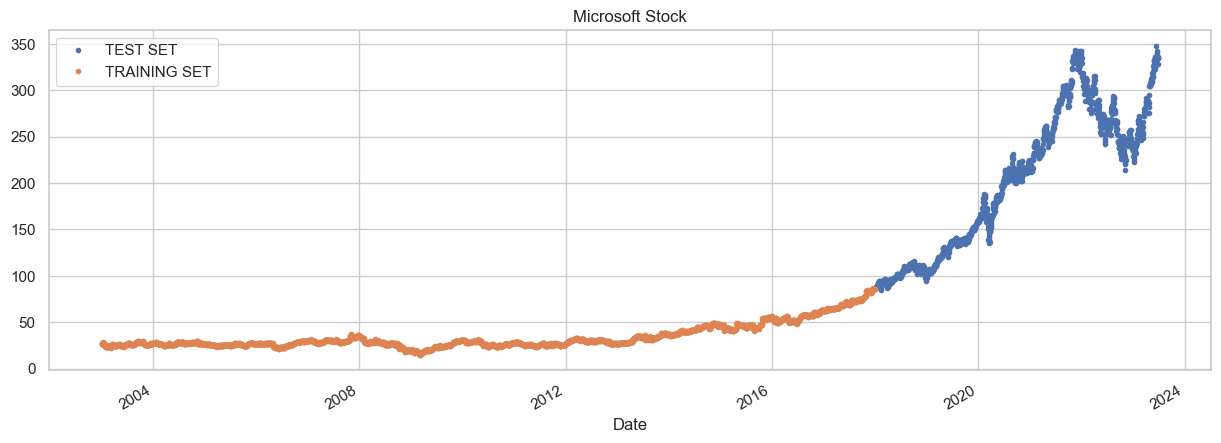

In [ ]:
msft_test[['Close']].rename(columns={'Close': 'TEST SET'}).join(
    msft_train[['Close']].rename(columns={'Close': 'TRAINING SET'}),
    how='outer', rsuffix='_train') \
    .plot(figsize=(15, 5), title='Microsoft Stock', style='.')
plt.show()


#### Prophet model expects the dataset to be named a specific way. We will rename our dataframe coulmns before feeding it into the model.
##### Datetime columns named : ds
##### Target: y

In [ ]:
msft_train_prophet = msft_train.reset_index() \
    .rename(columns={'Date': 'ds', 'Close': 'y'})

In [ ]:
msft_train_prophet.tail()

,ds,Open,High,Low,y,Adj Close,Volume
3771,2017-12-22,85.400002,85.629997,84.919998,85.510002,79.818298,14145800
3772,2017-12-26,85.309998,85.529999,85.029999,85.400002,79.715614,9891200
3773,2017-12-27,85.650002,85.980003,85.220001,85.709999,80.004997,14678000
3774,2017-12-28,85.900002,85.930000,85.550003,85.720001,80.014320,10594300
3775,2017-12-29,85.629997,86.050003,85.500000,85.540001,79.846313,18717400


In [ ]:
%%time
model=Prophet()
model.fit(msft_train_prophet)

13:35:15 - cmdstanpy - INFO - Chain [1] start processing
13:35:16 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 312 ms
Wall time: 1.28 s


In [ ]:
msft_test_prophet = msft_test.reset_index() \
    .rename(columns={'Date': 'ds', 'Close': 'y'})

msft_test_fcst=model.predict(msft_test_prophet)

In [ ]:
msft_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,76.265878,74.288326,80.152666,76.265878,76.265878,1.078909,1.078909,1.078909,-0.194021,-0.194021,-0.194021,1.272929,1.272929,1.272929,0.0,0.0,0.0,77.344786
1,2018-01-03,76.298003,74.545973,80.326241,76.298003,76.298003,1.039678,1.039678,1.039678,-0.186959,-0.186959,-0.186959,1.226637,1.226637,1.226637,0.0,0.0,0.0,77.337681
2,2018-01-04,76.330128,74.280307,79.988264,76.330128,76.330128,0.990268,0.990268,0.990268,-0.190899,-0.190899,-0.190899,1.181166,1.181166,1.181166,0.0,0.0,0.0,77.320396
3,2018-01-05,76.362254,74.563826,80.238499,76.362254,76.362254,0.948754,0.948754,0.948754,-0.187883,-0.187883,-0.187883,1.136637,1.136637,1.136637,0.0,0.0,0.0,77.311008
4,2018-01-08,76.458630,74.417155,80.173395,76.458630,76.458630,0.826049,0.826049,0.826049,-0.182703,-0.182703,-0.182703,1.008753,1.008753,1.008753,0.0,0.0,0.0,77.284679


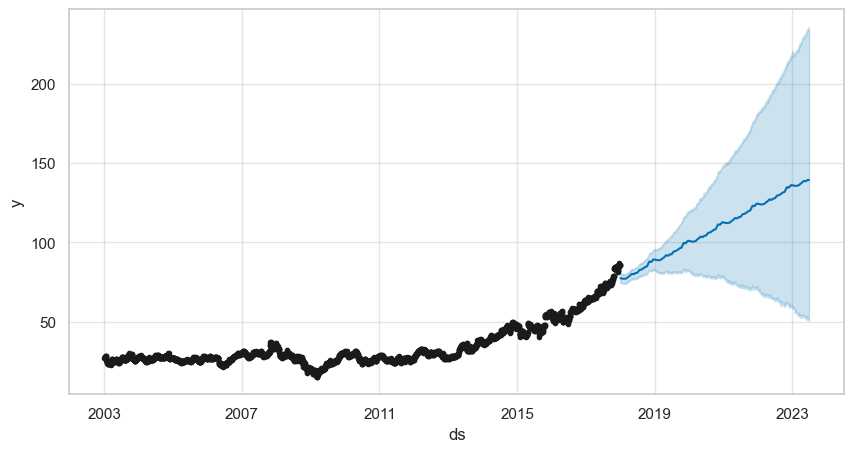

In [ ]:
fig, ax=plt.subplots(figsize=(10,5))
fig=model.plot(msft_test_fcst,ax=ax)
plt.show()

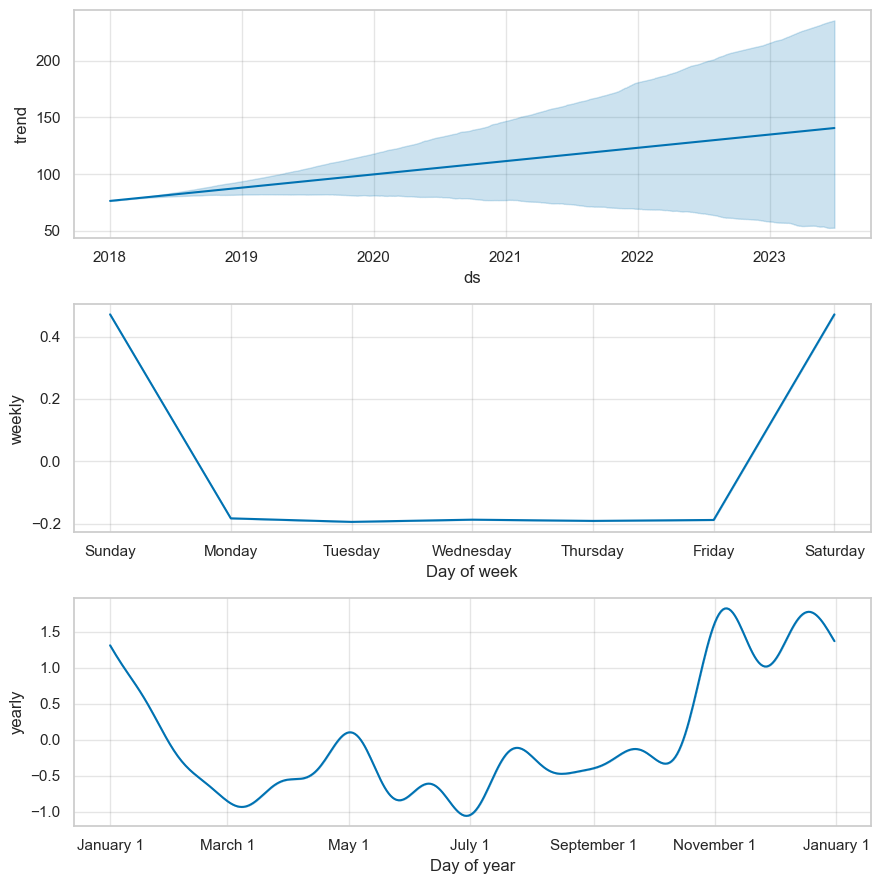

In [ ]:
fig=model.plot_components(msft_test_fcst)
plt.show()

## Compare Forecast to Actual

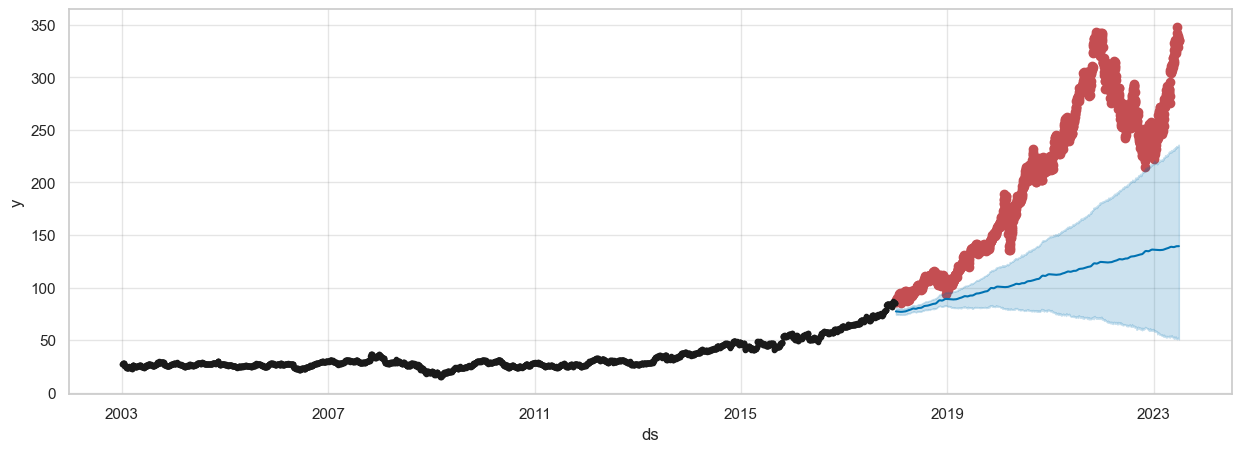

In [ ]:
f,ax=plt.subplots(figsize=(15,5))
ax.scatter(msft_test.index,msft_test['Close'],color='r')
fig=model.plot(msft_test_fcst,ax=ax)

#### First Month prediction

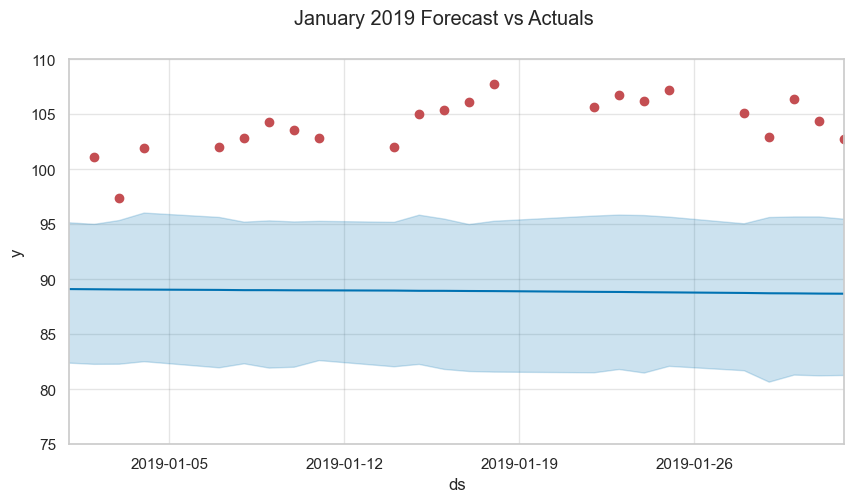

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(msft_test.index, msft_test['Close'], color='r')
fig = model.plot(msft_test_fcst, ax=ax)
ax.set_xbound(lower=pd.to_datetime('01-01-2019'), upper=pd.to_datetime('02-01-2019'))
ax.set_ylim(75,110)
plot = plt.suptitle('January 2019 Forecast vs Actuals')

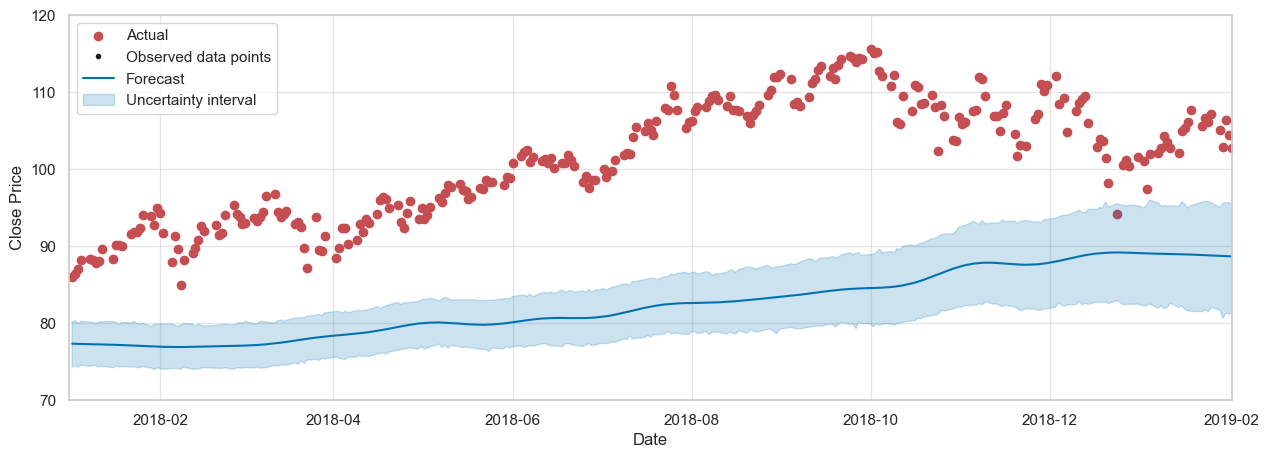

In [ ]:
# Assuming you have already trained the Prophet model and generated the forecast
# model and msft_test_fcst are placeholders, make sure to replace them with your actual model and forecast

# Plot the forecast with the actuals for a specific date range
f, ax = plt.subplots(figsize=(15, 5))

# Scatter plot for actual values
ax.scatter(msft_test.index, msft_test['Close'], color='r', label='Actual')

# Plot the forecast
fig = model.plot(msft_test_fcst, ax=ax, plot_cap=False, xlabel='Date', ylabel='Close Price')

# Set the x-axis limits and title
ax.set_xbound(lower=pd.to_datetime('01-01-2018'), upper=pd.to_datetime('02-01-2019'))
ax.set_ylim(70,120)

# Display the legend
ax.legend()

# Show the plot
plt.show()




### Evaluate the Model with ERROR metrics

In [ ]:
np.sqrt(mean_squared_error(y_true=msft_test['Close'],
                   y_pred=msft_test_fcst['yhat']))

111.08509788791473

In [ ]:
mean_absolute_error(y_true=msft_test['Close'],
                   y_pred=msft_test_fcst['yhat'])

93.66360480589992

In [ ]:
mean_absolute_percentage_error(y_true=msft_test['Close'],
                   y_pred=msft_test_fcst['yhat'])

40.897071068652366

### Adding Holidays

#### Adding holidays indicator will help the accuracy of the model.Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training.

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=msft.index.min(),
                        end=msft.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})

In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(msft_train_prophet)

13:35:19 - cmdstanpy - INFO - Chain [1] start processing
13:35:20 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 344 ms
Wall time: 1.79 s


In [ ]:
# Predict on training set with model
msft_test_fcst_with_hols = \
    model_with_holidays.predict(df=msft_test_prophet)

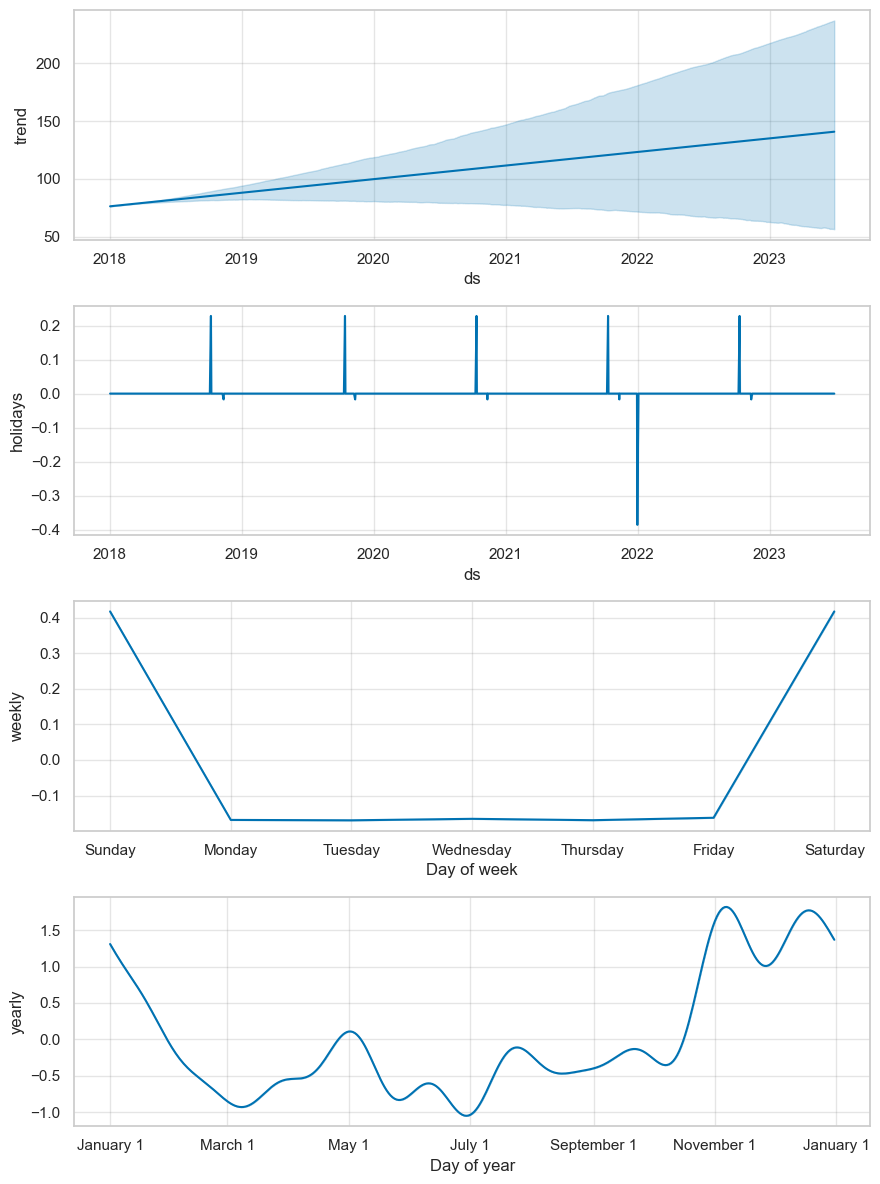

In [ ]:
fig = model_with_holidays.plot_components(
    msft_test_fcst_with_hols)
plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(10, 5))
#ax.scatter(msft_test.index, msft_test['Close'], color='g')
#fig = model.plot(msft_test_fcst_with_hols, ax=ax)
#ax.set_xbound(lower=pd.to_datetime('06-20-2019'), upper=pd.to_datetime('06-30-2019'))
#ax.set_ylim(70,110)
#plot = plt.suptitle('June 10 Predictions vs Actual')

In [ ]:
np.sqrt(mean_squared_error(y_true=msft_test['Close'],
                   y_pred=msft_test_fcst_with_hols['yhat']))

110.97217522378111

In [1]:
mean_absolute_error(y_true=msft_test['Close'],
                   y_pred=msft_test_fcst_with_hols['yhat'])

NameError: name 'mean_absolute_error' is not defined

In [ ]:
mean_absolute_percentage_error(y_true=msft_test['Close'],
                   y_pred=msft_test_fcst_with_hols['yhat'])

40.8420194282253

## Predict into the Future

In [ ]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)
forecast = model_with_holidays.predict(future)

In [ ]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2017-12-29 01:00:00,77.465422
1,2017-12-29 02:00:00,77.478483
2,2017-12-29 03:00:00,77.493075
3,2017-12-29 04:00:00,77.509192
4,2017-12-29 05:00:00,77.526812
